# Anomalies in RU2020 vote

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('cleaned.csv')
df['turnout'] = df['given']/np.maximum(1, df['nominal'])
df['support'] = df['yes']/np.maximum(1, df['given'])
df.head()

,region,tik,uik,nominal,given,received,damaged,yes,no,turnout,support
0,Адыгея,1 Адыгейская,1,2277,1925,1925,0,1749,176,0.845411,0.908571
1,Адыгея,1 Адыгейская,2,2694,2290,2290,7,2117,166,0.850037,0.924454
2,Адыгея,1 Адыгейская,3,2865,2441,2441,11,2171,259,0.852007,0.889390
3,Адыгея,1 Адыгейская,4,2054,1669,1669,8,1381,280,0.812561,0.827442
4,Адыгея,1 Адыгейская,5,714,607,607,1,473,133,0.850140,0.779242


In [4]:
# An index of how peculiar this number is. Anti-peculiar numbers are slightly. Most peculiar are ==1 
def find_funny(df):
    df['funny_turnout'] = (np.floor(np.ceil(df['given'].values/df['nominal']*100)/100
                                    *df['nominal'])==df['given'])*1
    df['funny_support'] = (np.floor(np.ceil(df['yes'].values/df['given']*100)/100*
                                    df['given'])==df['yes'])*1
    return df

df = find_funny(df)
df.loc[np.logical_and(df['funny_support']==1, df['received']>200)]

,region,tik,uik,nominal,given,received,damaged,yes,no,turnout,support,funny_turnout,funny_support
4,Адыгея,1 Адыгейская,5,714,607,607,1,473,133,0.850140,0.779242,0,1
5,Адыгея,1 Адыгейская,6,1065,878,878,3,746,129,0.824413,0.849658,0,1
18,Адыгея,2 Гиагинская,22,486,434,434,3,386,45,0.893004,0.889401,0,1
37,Адыгея,3 Кошехабльская,43,720,659,659,2,579,78,0.915278,0.878604,0,1
44,Адыгея,3 Кошехабльская,50,531,521,521,1,463,57,0.981168,0.888676,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85125,Ямало-Ненецкий,11 Тазовская,1105,1428,951,951,15,846,90,0.665966,0.889590,0,1
85132,Ямало-Ненецкий,12 Шурышкарская,1201,215,206,206,5,189,12,0.958140,0.917476,1,1
85140,Ямало-Ненецкий,13 Ямальская,1301,579,449,449,7,318,124,0.775475,0.708241,0,1
85144,Ямало-Ненецкий,13 Ямальская,1305,1518,1314,1314,0,1130,184,0.865613,0.859970,0,1


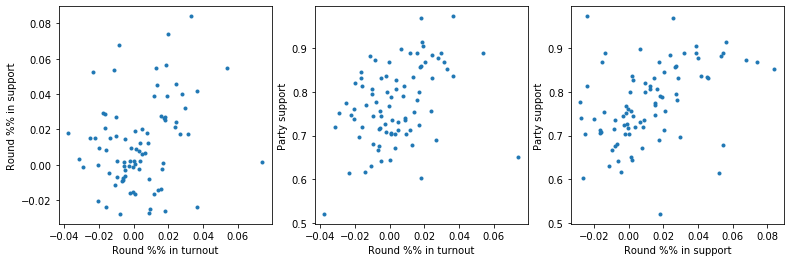

In [5]:
# Estimate the prevalence of weird numbers
dfsum = df.groupby('region').agg({'funny_support': [np.mean], 
                                  'funny_turnout': [np.mean],
                                  'support': [np.mean]})
dfsum.columns = ['fun_support', 'fun_turnout', 'support']
dfsum['base_fun_support'] = 0
dfsum['base_fun_turnout'] = 0

nexp = 100
sigma = 0.005 # Noisification coefficient
for iexp in range(nexp):
    temp = df.copy()
    temp['given'] = np.round(temp['nominal']*(temp['turnout']+np.random.normal(size=len(df))*sigma))
    temp['given'] = np.maximum(0, np.minimum(temp['nominal'], temp['given'])).astype(int)
    temp['yes'] = np.round(temp['given']*(temp['turnout']+np.random.normal(size=len(df))*sigma))
    temp['yes'] = np.maximum(0, np.minimum(temp['given'], temp['yes'])).astype(int)
    temp = find_funny(temp)
    tempsum = temp.groupby('region').agg({'funny_support': [np.mean], 
                                          'funny_turnout': [np.mean]})
    dfsum['base_fun_turnout'] = dfsum['base_fun_turnout'] + tempsum[('funny_turnout','mean')]/nexp    
    dfsum['base_fun_support'] = dfsum['base_fun_support'] + tempsum[('funny_support','mean')]/nexp

plt.figure(figsize=(13,4))
plt.subplot(131);
plt.plot(dfsum['fun_turnout']-dfsum['base_fun_turnout'], dfsum['fun_support']-dfsum['base_fun_support'], '.');
plt.xlabel('Round %% in turnout');
plt.ylabel('Round %% in support');
plt.subplot(132)
plt.plot(dfsum['fun_turnout']-dfsum['base_fun_turnout'], dfsum['support'], '.');
plt.xlabel('Round %% in turnout');
plt.ylabel('Party support');
plt.subplot(133)
plt.plot(dfsum['fun_support']-dfsum['base_fun_support'], dfsum['support'], '.');
plt.xlabel('Round %% in support');
plt.ylabel('Party support');

In [11]:
def latinize(s):
    """Latinsca"""
    a1 = 'абвгдежзиклмнопрстуфхцчшщэюяьъый'
    a2 = "a b v g d e zh z i k l m n o p r s t u f h ts ch sh sch e yu ya ' ' y y"
    a1 = a1 + a1.upper()
    a2 = a2 + ' ' + a2.upper()
    a2 = a2.split(' ')
    t = {a1[i]: a2[i] for i in range(len(a1))}
    return ''.join([t[c] if c in t else c for c in s])
    
latinize('Уфа1')

'Ufa1'

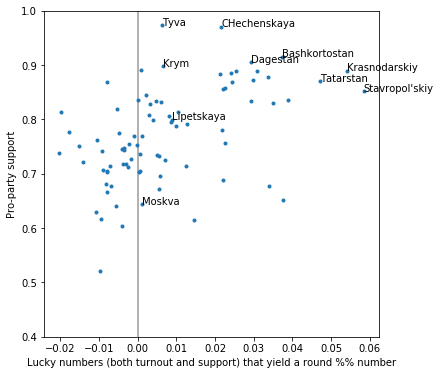

In [12]:
dfsum['weirdness'] = (dfsum.fun_support-dfsum.base_fun_support + dfsum.fun_turnout - dfsum.base_fun_turnout)/2

plt.figure(figsize=(6, 6), facecolor='white')
plt.plot(dfsum.weirdness, dfsum.support, '.');
plt.xlabel('Lucky numbers (both turnout and support) that yield a round %% number');
plt.ylabel('Pro-party support');
label_these = ['Тыва', 'Чеченская', 'Башкортостан', 'Краснодарский', 'Татарстан', 
               'Дагестан', 'Крым', 'Москва', 'Липецкая', 'Ставропольский']
plt.vlines(0, 0, 1, alpha=0.4)
plt.ylim(0.4, 1)
for i in range(len(dfsum)):
    if dfsum.index.tolist()[i] in label_these:
        plt.text(dfsum.weirdness[i], dfsum.support[i], 
                  latinize(dfsum.index.tolist()[i]));

In [5]:
# Record strangeness in turnout
ind = np.argsort(dfsum['fun_turnout']-dfsum['base_fun_turnout'])
dfsum.iloc[ind]

,fun_support,fun_turnout,support,base_fun_support,base_fun_turnout
region,,,,,
Ненецкий,0.527273,0.345455,0.520267,0.515455,0.387818
Смоленская,0.356873,0.220681,0.751487,0.363632,0.252106
Удмуртская,0.297890,0.189873,0.720672,0.295527,0.221181
Курская,0.398014,0.268953,0.774611,0.381065,0.294540
Омская,0.240506,0.113924,0.614405,0.185949,0.138734
...,...,...,...,...,...
Ставропольский,0.287092,0.214392,0.851578,0.203539,0.181209
Адыгея,0.241245,0.202335,0.836264,0.200156,0.166187
Тыва,0.240437,0.300546,0.973653,0.266995,0.261366


In [6]:
# Record strangeness in support
ind = np.argsort(dfsum['fun_support']-dfsum['base_fun_support'])
dfsum.iloc[ind]

,fun_support,fun_turnout,support,base_fun_support,base_fun_turnout
region,,,,,
Мурманская,0.425386,0.384220,0.603165,0.452796,0.368199
Тыва,0.240437,0.300546,0.973653,0.266995,0.261366
Вологодская,0.318795,0.279335,0.741353,0.345099,0.267954
Чукотский,0.436364,0.400000,0.812856,0.462364,0.417091
Забайкальский,0.372043,0.297849,0.776175,0.397462,0.303441
...,...,...,...,...,...
Краснодарский,0.197814,0.183357,0.889728,0.143025,0.129767
Башкортостан,0.354230,0.302663,0.915006,0.296768,0.284166
Брянская,0.362069,0.272414,0.872542,0.296621,0.279448
